# Kernel methods for machine learning - image classification challenge

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Helper functions

In [67]:
from sklearn.preprocessing import LabelBinarizer

## Load data

In [2]:
Xtr = np.array(pd.read_csv('data/Xtr.csv', header=None, sep=',', usecols=range(3072)))
Xte = np.array(pd.read_csv('data/Xte.csv', header=None, sep=',', usecols=range(3072)))
Ytr = np.array(pd.read_csv('data/Ytr.csv', sep=',', usecols=[1])).squeeze()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
Ytr

array([8, 9, 3, ..., 1, 7, 5], dtype=int64)

## Visualization

In [4]:
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

X = scale(Xtr)

automobile


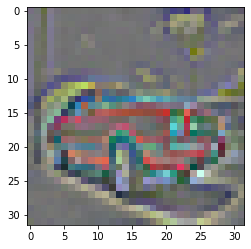

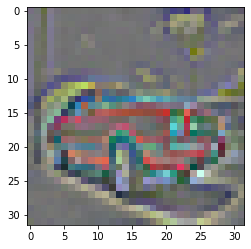

In [5]:
i = 1000
print(classes[Ytr[i]])
tmp = scale(Xtr[i])
r = tmp[:1024].reshape([32, 32])
g = tmp[1024:2048].reshape([32, 32])
b = tmp[2048:].reshape([32, 32])
img = np.dstack((r, g, b))

plt.imshow(scale(img))
plt.show()

tmp = X[i]
r = tmp[:1024].reshape([32, 32])
g = tmp[1024:2048].reshape([32, 32])
b = tmp[2048:].reshape([32, 32])
img = np.dstack((r, g, b))

plt.imshow(scale(img))
plt.show()

## Kernels

In [62]:
class Kernel:
    
    def __init__(self, X, sigma):
        self.X = X
        self.sigma = sigma


class LinearKernel(Kernel):
    
    def __init__(self, X, sigma=None):
        super().__init__(X, sigma)
    
    def similarity_matrix(self):
        l = len(self.X)
        K = np.empty([l, l])
        for i in range(l):
            for j in range(i, l):
                K[i, j] = K[j, i] = np.dot(self.X[i], self.X[j])
        return K
    
    def similarity(self, x):
        return np.array([np.dot(x_i, x) for x_i in self.X])


class GaussianKernel(Kernel):
    
    def __init__(self, X, sigma):
        super().__init__(X, sigma)
    
    def similarity_matrix(self):
        l = len(self.X)
        K = np.empty([l, ll])
        for i in range(ll):
            for j in range(i, ll):
                K[i, j] = K[j, i] = np.exp(-np.linalg.norm(self.X[i] - self.X[j]) ** 2 / (2 * self.sigma ** 2))
        return K
    
    def similarity(self, x):
        return np.array([np.exp(-np.linalg.norm(x_i - x) ** 2 / (2 * self.sigma ** 2)) for x_i in self.X])
    

kernels = {'linear': LinearKernel, 'rbf': GaussianKernel}

## Algorithms

In [85]:
class KernelRidgeClassifier:
    
    def __init__(self, lambd=1.0, kernel='rbf', sigma=10):
        self.lambd = lambd
        self.kernel_class = kernels[kernel]
        self.sigma = sigma
    
    def fit(self, X, y):
        Y = LabelBinarizer(pos_label=1, neg_label=-1).fit_transform(y)
        # initialize kernel
        self.kernel = self.kernel_class(X, self.sigma)
        K = self.kernel.similarity_matrix()
        # get second term of KRR
        diag = np.zeros_like(K)
        np.fill_diagonal(diag, self.lambd * len(X))
        # compute coefficients num_classes times, one-vs-all
        # @ is matrix multiplication, equivalent to np.matmul
        self.alpha = []
        for c in set(y):
            self.alpha.append(np.linalg.inv(K + diag) @ Y[:,c])
        self.alpha = np.array(self.alpha)
    
    def predict(self, X):
        # TODO
        return np.array([np.sum([alpha * self.kernel.similarity(x) for alpha in self.alpha]) for x in X])

## Tests

In [69]:
set(Ytr)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [36]:
subset = Xtr[:100]
sub_y = Ytr[:100]
len(subset)

100

In [86]:
clf = KernelRidgeClassifier(kernel='linear')
clf.fit(subset, sub_y)

In [87]:
clf.alpha

array([[-0.00979196, -0.0089491 , -0.00965786, -0.00935608, -0.00983955,
        -0.00929625, -0.00948132,  0.00961549, -0.00965994, -0.00958097,
        -0.00946024, -0.00947924, -0.00954396, -0.00945198, -0.00973134,
        -0.00996816, -0.00954213, -0.00960041, -0.00986029, -0.00976087,
        -0.00949415, -0.00989168, -0.00963161, -0.00968237, -0.0095559 ,
        -0.00970641,  0.00955778, -0.009454  , -0.00956109, -0.00956513,
        -0.00961544, -0.00957469, -0.00946362, -0.00948115,  0.00962964,
        -0.00946198, -0.00953007, -0.00953103, -0.00958184, -0.00921008,
        -0.00964576, -0.00930584, -0.00934579, -0.00982812, -0.00945811,
        -0.00956023, -0.00942512, -0.00995932, -0.00970988, -0.0094868 ,
        -0.00959898, -0.00954253, -0.00930329, -0.00945205, -0.00923819,
        -0.00997101, -0.00946407,  0.00967982, -0.00958884, -0.00940229,
        -0.00945552, -0.00955923, -0.00960891, -0.00983054, -0.00951776,
        -0.00965291, -0.00945844, -0.00950368, -0.0

In [30]:
kernel = LinearKernel(subset)
K = kernel.similarity_matrix()

In [34]:
diag = np.zeros_like(K)
np.fill_diagonal(diag, 1 * len(subset))

In [41]:
(np.linalg.inv(K + diag) @ sub_y).shape

(100,)

In [47]:
from sklearn.datasets import make_regression

In [48]:
X, y = make_regression()

In [71]:
clf = KernelRidgeClassifier(kernel='linear')
clf.fit(X, y)

ValueError: Unknown label type: (array([-186.65004386,  172.26450221,   87.63704423,  -29.28412983,
        -22.24395372,  -71.82116385,  -89.42881881,   17.74348851,
        -91.98780414, -154.45581274, -205.99932861,  -22.63441729,
         80.33411238,  165.25449566,  -44.0192526 ,  -41.62930277,
          2.6915323 ,   25.63599589, -204.26464553,   -5.20350154,
         30.39431319,  143.34409091, -160.60690103,  185.24639633,
         35.93359346, -246.21709837,   26.8683438 ,  -24.28088814,
       -145.40329222,    4.29923095,  162.02076367,  195.63478682,
        -43.44663351,  -46.87620352,  -86.10823866,   67.80780969,
        -85.5429439 ,   70.91738778, -252.40816249,  -59.4790153 ,
        179.55908478, -190.63917353,   57.02974444,  -16.0839174 ,
         27.5632778 , -142.49919578,  -59.86140171,  -81.83888326,
         16.1188696 ,   -3.75152529,   17.81912076, -121.25224876,
        -13.21465601,  -28.25819551,  -29.45393551,  -97.76479893,
       -157.26752833,  -76.43257306,    4.12426895, -111.83328368,
       -164.84820191,  416.46809976,  -75.12180539,   65.26988992,
        -49.24504074,   95.68664372,   25.64018138,  -84.8486868 ,
       -203.4716216 ,  -87.62260607,  -95.19403578,   68.93634348,
       -143.79565482, -213.04633694,  136.5947441 ,   13.9802413 ,
       -117.93079608,  -13.22627553,  -26.36814035,   76.11302677,
        -48.22655653,   69.13418518,  -24.62865874, -178.31520356,
       -196.92131082,    3.66423433,  115.76874031, -122.61033802,
        -27.32410214, -222.52264124,  250.88270878,  -97.00485882,
        -73.66712877,  -48.58790034,   20.54499847,  177.5811756 ,
        -42.81779086,   48.48160004,  122.08246258,   55.00321204]),)

In [65]:
y

array([-186.65004386,  172.26450221,   87.63704423,  -29.28412983,
        -22.24395372,  -71.82116385,  -89.42881881,   17.74348851,
        -91.98780414, -154.45581274, -205.99932861,  -22.63441729,
         80.33411238,  165.25449566,  -44.0192526 ,  -41.62930277,
          2.6915323 ,   25.63599589, -204.26464553,   -5.20350154,
         30.39431319,  143.34409091, -160.60690103,  185.24639633,
         35.93359346, -246.21709837,   26.8683438 ,  -24.28088814,
       -145.40329222,    4.29923095,  162.02076367,  195.63478682,
        -43.44663351,  -46.87620352,  -86.10823866,   67.80780969,
        -85.5429439 ,   70.91738778, -252.40816249,  -59.4790153 ,
        179.55908478, -190.63917353,   57.02974444,  -16.0839174 ,
         27.5632778 , -142.49919578,  -59.86140171,  -81.83888326,
         16.1188696 ,   -3.75152529,   17.81912076, -121.25224876,
        -13.21465601,  -28.25819551,  -29.45393551,  -97.76479893,
       -157.26752833,  -76.43257306,    4.12426895, -111.83328

In [66]:
clf.predict(y)

array([-356624.41461848,  329138.56321656,  167444.42675918,
        -55951.95929598,  -42500.58993259, -137225.68709069,
       -170867.89532544,   33901.7397125 , -175757.24134144,
       -295112.2467751 , -393594.28188278,  -43246.63230129,
        153491.02100215,  315744.83755573,  -84105.74069463,
        -79539.3637413 ,    5142.59792996,   48981.62270629,
       -390279.89564702,   -9942.11226196,   58073.14011939,
        273881.54565208, -306864.87331199,  353942.52412336,
         68656.8107199 , -470436.68867755,   51336.21821006,
        -46392.47513932, -277815.97529352,    8214.36035833,
        309566.28139919,  373791.1863692 ,  -83011.66141357,
        -89564.39706695, -164523.40203883,  129557.53953732,
       -163443.31703949,  135498.88003863, -482265.6953629 ,
       -113644.06123797,  343076.01634754, -364246.27746217,
        108964.34207963,  -30730.86675981,   52663.99946207,
       -272267.23995884, -114374.67092549, -156366.12363785,
         30797.64845338,

## Comparison with *sklearn*

In [7]:
from sklearn.linear_model import RidgeClassifier

In [8]:
clf = RidgeClassifier()
clf.fit(Xtr, Ytr)

RidgeClassifier()

In [42]:
clf.predict(Xte[:10])

array([1, 5, 1, 0, 1, 4, 6, 0, 1, 6], dtype=int64)